# Regression with LTN

This is a basic example in which we use LTN for training a regression estimator. The essence of regression is to approximate a function $f(x)=y$ where $y$ can be any real value or tensor (as opposed to classifiers which project values to $[0,1]$). We are given examples of this function $x_i$, $y_i$ with $f(x_i)=y_i$. From the examples, we need to estimate a function $f^\ast$ that approximates $f$.

In LTN we can directly model this by defining $f^\ast$ as a learnable/trainable function with some parameters that are constrained through data. Additionnally, we need a notion of $=$. Here, we use an euclidian distance/similarity to get a smooth $=$ function. We define the following language and theory:
- a set of points $x_i$ and $y_i$
- a definition of a predicate for equality, modeled as a smooth equality function $\mathrm{eq}(x,y)=\exp\bigg(-\sqrt{\sum_j (x_j-y_j)^2}\bigg)$
- a learnable function $f^\ast$ for which the following constraint hold: $\mathrm{eq}(f^\ast(x_i),y_i)$. The function $f^\ast$ approximates $f(x_i)=y_i$
- here, $f^\ast$ is modeled using a linear function with $f^\ast(x)=Wx+b$

In [1]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logictensornetworks as ltn
import pandas as pd

# Data

Load the [real estate dataset](https://www.kaggle.com/quantbruce/real-estate-price-prediction): 
- 414 samples,
- 6 float features: transaction date (converted to float, eg. `2012.917` is equivalent to december), house age, distance to station, # of convenience stores nearby, lat, long,
- y: house price per unit area

In [2]:
df = pd.read_csv("real-estate.csv")
df = df.sample(frac=1) #shuffle
df.head(5)

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
356,357,2012.833,10.3,211.4473,1,24.97417,121.52999,45.3
101,102,2012.833,12.7,170.1289,1,24.97371,121.52984,32.9
138,139,2013.167,10.0,942.4664,0,24.97843,121.52406,43.5
214,215,2013.583,18.1,1783.1800,3,24.96731,121.51486,20.9
309,310,2013.250,30.3,1264.7300,0,24.94883,121.52954,19.1


We use 330 examples for training and 84 examples for testing.

In [3]:
x = df[['X1 transaction date', 'X2 house age',
       'X3 distance to the nearest MRT station',
       'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']]
y = df[['Y house price of unit area']]

batch_size=128
ds_train = tf.data.Dataset.from_tensor_slices((x[:330],y[:330])).batch(batch_size)
ds_test = tf.data.Dataset.from_tensor_slices((x[330:],y[330:])).batch(batch_size)

# LTN

In [4]:
f = ltn.Function.MLP(input_shapes=[6],output_shape=[1],hidden_layer_sizes=(8,8))

In [5]:
eq = ltn.Predicate.Lambda(
    lambda args: tf.exp(-0.05*tf.sqrt(tf.reduce_sum(tf.square(args[0]-args[1]),axis=1)))        
    #lambda args: 1/(1+0.5*tf.sqrt(tf.reduce_sum(tf.square(args[0]-args[1]),axis=1)))
)


In [6]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=2),semantics="exists")

In [7]:
@tf.function
def axioms(x_data, y_data):
    x = ltn.variable("x", x_data)
    y = ltn.variable("y", y_data)
    return Forall(ltn.diag(x,y), eq([f(x),y]))

Initialize all layers and the static graph.



In [8]:
for x, y in ds_test:
    print("Initial sat level %.5f"%axioms(x,y))
    break

Initial sat level 0.00000


# Training

Define the metrics. While training, we measure:
1. The level of satisfiability of the Knowledge Base of the training data.
2. The level of satisfiability of the Knowledge Base of the test data.
3. The training accuracy.
4. The test accuracy.

In [9]:
metrics_dict = {
    'train_sat': tf.keras.metrics.Mean(name='train_sat'),
    'test_sat': tf.keras.metrics.Mean(name='test_sat'),
    'train_accuracy': tf.keras.metrics.RootMeanSquaredError(name="train_accuracy"),
    'test_accuracy': tf.keras.metrics.RootMeanSquaredError(name="test_accuracy")
}

Define the training and testing steps.

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
@tf.function
def train_step(x, y):
    # sat and update
    with tf.GradientTape() as tape:
        sat = axioms(x, y)
        loss = 1.-sat
    gradients = tape.gradient(loss, f.trainable_variables)
    optimizer.apply_gradients(zip(gradients, f.trainable_variables))
    sat = axioms(x, y)
    metrics_dict['train_sat'](sat)
    # accuracy
    metrics_dict['train_accuracy'](y,f.model(x))
    
@tf.function
def test_step(x, y):
    # sat
    sat = axioms(x, y)
    metrics_dict['test_sat'](sat)
    # accuracy
    metrics_dict['test_accuracy'](y,f.model(x))

Training

In [11]:
import commons

EPOCHS = 1000

commons.train(
    EPOCHS,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    csv_path="regression_results.csv",
    track_metrics=50
)

Epoch 0, train_sat: 0.0000, test_sat: 0.0000, train_accuracy: 310.8821, test_accuracy: 295.9734
Epoch 50, train_sat: 0.6984, test_sat: 0.7092, train_accuracy: 9.6160, test_accuracy: 7.8660
Epoch 100, train_sat: 0.7082, test_sat: 0.7151, train_accuracy: 9.2455, test_accuracy: 7.6387
Epoch 150, train_sat: 0.7147, test_sat: 0.7180, train_accuracy: 9.0105, test_accuracy: 7.5855
Epoch 200, train_sat: 0.7206, test_sat: 0.7213, train_accuracy: 8.8605, test_accuracy: 7.5081
Epoch 250, train_sat: 0.7239, test_sat: 0.7253, train_accuracy: 8.8028, test_accuracy: 7.4300
Epoch 300, train_sat: 0.7258, test_sat: 0.7279, train_accuracy: 8.7740, test_accuracy: 7.3895
Epoch 350, train_sat: 0.7268, test_sat: 0.7295, train_accuracy: 8.7607, test_accuracy: 7.3681
Epoch 400, train_sat: 0.7274, test_sat: 0.7304, train_accuracy: 8.7539, test_accuracy: 7.3598
Epoch 450, train_sat: 0.7278, test_sat: 0.7311, train_accuracy: 8.7477, test_accuracy: 7.3545
Epoch 500, train_sat: 0.7281, test_sat: 0.7315, train_accur

In [12]:
import seaborn as sns
sns.set(font_scale=1.2)

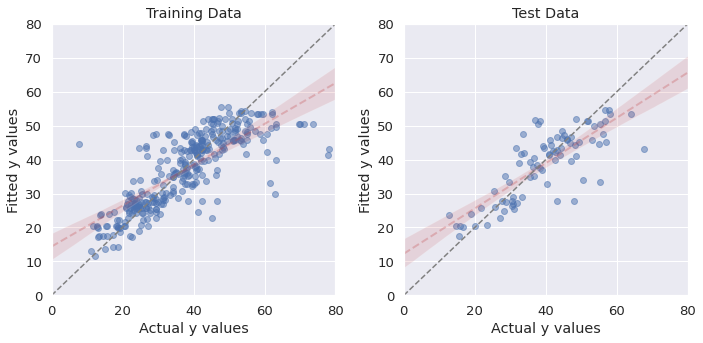

In [13]:


fig, axs = plt.subplots(1,2,figsize=(10,5))
ax = axs[0]
data = {'y_pred':[],'y_true':[]}
for x,y in ds_train:
    data['y_pred'].extend(f.model(x)[:,0].numpy())
    data['y_true'].extend(y[:,0].numpy())
df = pd.DataFrame(data,columns=['y_pred','y_true'])
ax.set_xlim(0,80)
ax.set_ylim(0,80)
sns.regplot("y_true","y_pred",data=df,ax=ax,truncate=False,
            scatter_kws={'alpha':0.5},line_kws={'color':'r','alpha':0.3,'linestyle':'--','linewidth':2})
ax.plot([0,100],[0,100],color="gray",linestyle="--")
ax.set_xlabel("Actual y values")
ax.set_ylabel("Fitted y values")
ax.set_title("Training Data")

ax = axs[1]
data = {'y_pred':[],'y_true':[]}
for x,y in ds_test:
    data['y_pred'].extend(f.model(x)[:,0].numpy())
    data['y_true'].extend(y[:,0].numpy())
df = pd.DataFrame(data,columns=['y_pred','y_true'])
ax.set_ylim(0,80)
ax.set_xlim(0,80)
sns.regplot("y_true","y_pred",data=df,ax=ax,truncate=False,
            scatter_kws={'alpha':0.5},line_kws={'color':'r','alpha':0.3,'linestyle':'--','linewidth':2})
ax.plot([0,100],[0,100],color="gray",linestyle="--")
ax.set_xlabel("Actual y values")
ax.set_ylabel("Fitted y values")
ax.set_title("Test Data")
plt.tight_layout()
#plt.savefig("ex_regression.pdf")